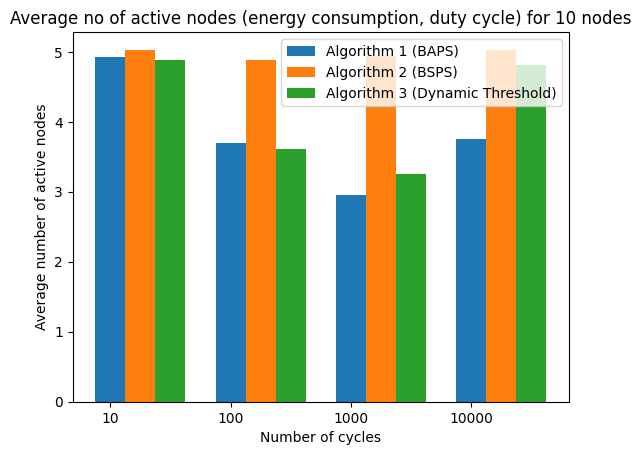

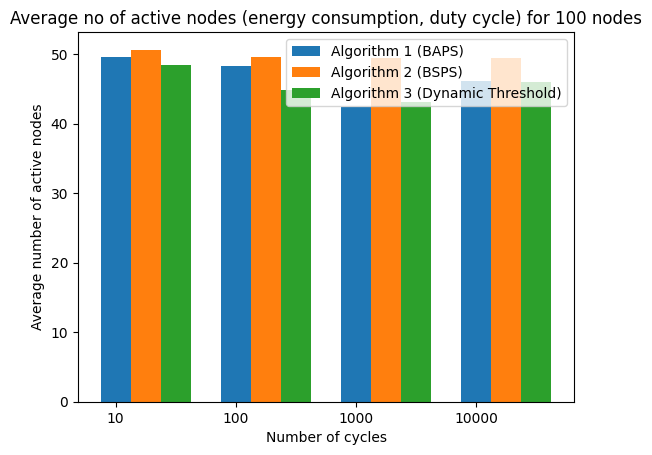

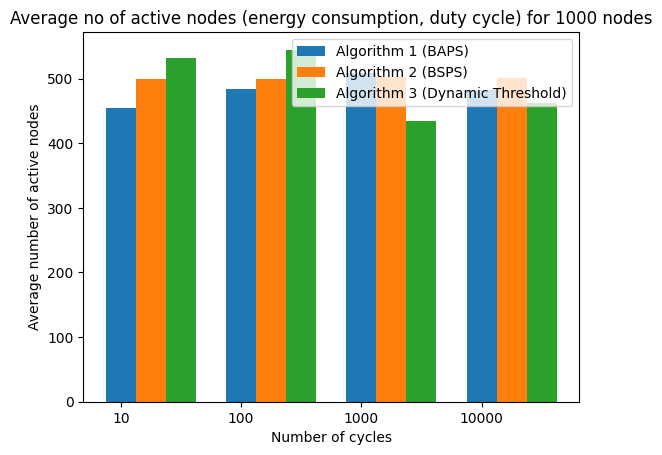

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

def generate_random_route_tree(num_nodes):
    """
    Generates a random route tree with the specified number of nodes.
    """
    tree = [[0]]
    node_count = 1
    while node_count < num_nodes:
        parent_node_count = len(tree[-1])
        child_nodes = [parent_node_count+i for i in range(parent_node_count+1)]
        tree.append(child_nodes)
        node_count += parent_node_count+1
    return tree

# Run the simulation for different numbers of cycles and different route tree sizes
num_cycles_list = [10, 100, 1000, 10000]
route_tree_sizes = [10, 100, 1000]
results = []
for route_tree_size in route_tree_sizes:
    for num_cycles in num_cycles_list:
        # Generate random node states for testing
        num_nodes = route_tree_size
        node_states = [[random.randint(0, 1) for j in range(num_cycles)] for i in range(num_nodes)]

        # Generate a random route tree
        route_tree = generate_random_route_tree(num_nodes)

        # Run the algorithms for the specified number of cycles
        num_runs = 100
        active_nodes_tdma = []
        active_nodes_dynamic = []
        active_nodes_bsps = []
        for i in range(num_runs):
            # Run Algorithm 1
            active_nodes_tdma.append(tdma_node_filtering(node_states))

            # Run Algorithm 2
            active_nodes_dynamic.append(dynamic_threshold_node_filtering(route_tree, node_states))

            # Run Algorithm 3
            active_nodes_bsps.append(tdma_node_bsps(node_states))

            # Update node states for next cycle
            for j in range(num_nodes):
                node_states[j].append(random.randint(0, 1))

        # Compute average number of active nodes for each algorithm
        avg_active_nodes_tdma = sum([len(x) for x in active_nodes_tdma]) / num_runs
        avg_active_nodes_dynamic = sum([len(x) for x in active_nodes_dynamic]) / num_runs
        avg_active_nodes_bsps = sum([len(x) for x in active_nodes_bsps]) / num_runs

        # Save the results
        results.append((route_tree_size, num_cycles, avg_active_nodes_tdma, avg_active_nodes_bsps, avg_active_nodes_dynamic))

# Plot the results as separate bar graphs for each route tree size
for route_tree_size in route_tree_sizes:
    filtered_results = [result for result in results if result[0] == route_tree_size]
    num_cycles_list = [result[1] for result in filtered_results]
    tdma_values = [result[2] for result in filtered_results]
    bsps_values = [result[3] for result in filtered_results]
    dynamic_values = [result[4] for result in filtered_results]

    labels = [str(num_cycles) for num_cycles in num_cycles_list]
    x = np.array([i for i in range(len(labels))])
    width = 0.25

    fig, ax = plt.subplots()
    plt.title(f'Average no of active nodes (energy consumption, duty cycle) for {route_tree_size} nodes')
    rects1 = ax.bar(x , tdma_values, width, label='Algorithm 1 (BAPS)')
    rects2 = ax.bar(x + width, bsps_values, width, label='Algorithm 2 (BSPS)')
    rects3 = ax.bar(x + width*2, dynamic_values, width, label='Algorithm 3 (Dynamic Threshold)')

    ax.set_ylabel('Average number of active nodes')
    ax.set_xlabel('Number of cycles')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    plt.show()


TDMA-based slot matrix for 10 nodes:
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]
Linear dynamic time slot sizing slot matrix for 10 nodes:
[[126.69396885   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          78.56682798   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          62.88793019   0.           0.
    0.           0.           0.           0.           0.   

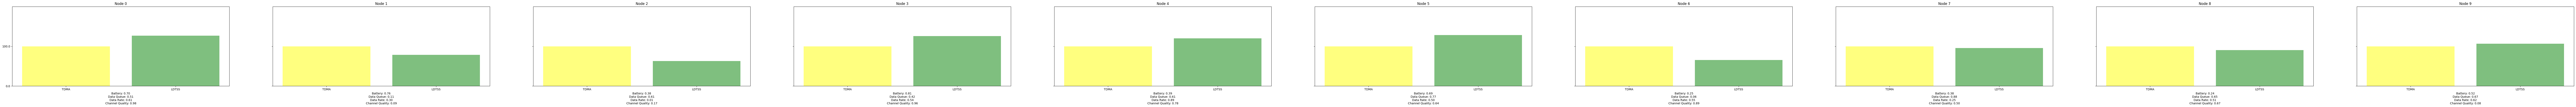

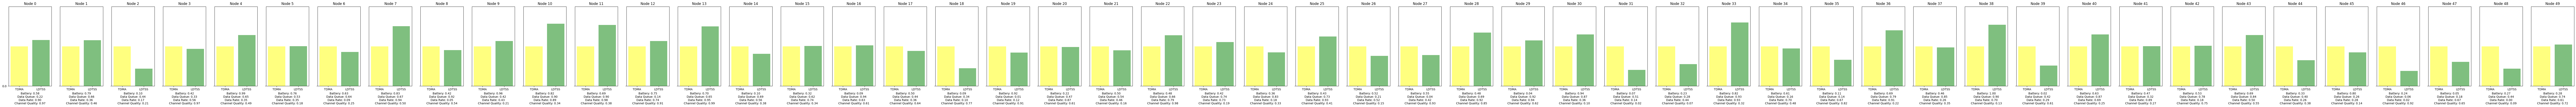

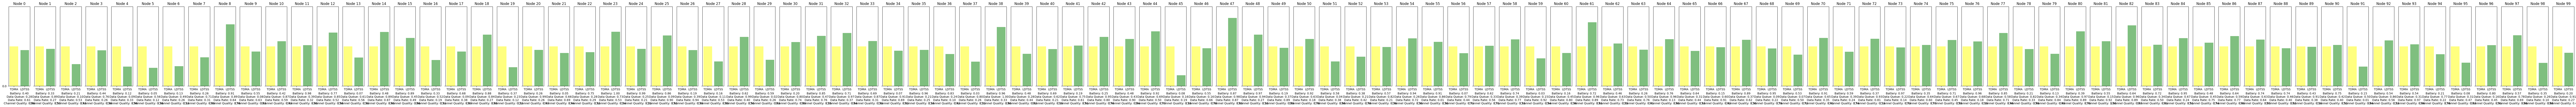

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# TDMA-based node scheduling algorithm
def tdma_node_scheduling(active_nodes, T):
    num_nodes = len(active_nodes)
    time_per_slot = T / num_nodes
    slot_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        slot_matrix[i][i] = time_per_slot
    return slot_matrix

# Linear dynamic time slot sizing algorithm
def linear_dynamic_time_slot_sizing(active_nodes, node_states, weights, T):
    num_nodes = len(active_nodes)
    priority_scores = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_idx = active_nodes[i]
        B = weights['wB'] * node_states[node_idx][0]
        max_B = np.max(node_states[:,0])
        Q = weights['wQ'] * node_states[node_idx][1]
        max_Q = np.max(node_states[:,1])
        R = weights['wR'] * node_states[node_idx][2]
        max_R = np.max(node_states[:,2])
        C = weights['wC'] * node_states[node_idx][3]
        max_C = np.max(node_states[:,3])
        priority_scores[i] = B / max_B + Q / max_Q + R / max_R + C / max_C
    sorted_nodes = [x for _, x in sorted(zip(priority_scores, active_nodes), reverse=True)]
    total_priority = np.sum(priority_scores)
    slot_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        node_idx = sorted_nodes[i]
        priority = priority_scores[i]
        time_per_slot = priority / total_priority * T
        slot_matrix[i][i] = time_per_slot
    return slot_matrix

# Example usage
num_active_nodes = [10, 50, 100]
T = 1000
weights = {'wB': 0.35, 'wQ': 0.275, 'wR': 0.275, 'wC': 0.1}

for num_nodes in num_active_nodes:
    node_states = np.random.rand(num_nodes, 4)
    active_nodes = list(range(num_nodes))

    # TDMA-based node scheduling
    tdma_slot_matrix = tdma_node_scheduling(active_nodes, T)
    print(f"TDMA-based slot matrix for {num_nodes} nodes:")
    print(tdma_slot_matrix)

    # Linear dynamic time slot sizing
    ldtss_slot_matrix = linear_dynamic_time_slot_sizing(active_nodes, node_states, weights, T)
    print(f"Linear dynamic time slot sizing slot matrix for {num_nodes} nodes:")
    print(ldtss_slot_matrix)

    # Plot the results
    fig, axs = plt.subplots(ncols=num_nodes, sharey=True)
    fig.set_size_inches(160, 5)
    for i, node_idx in enumerate(active_nodes):
        axs[i].bar(['TDMA', 'LDTSS'], [tdma_slot_matrix[i][i], ldtss_slot_matrix[i][i]], color = ['yellow','green'] ,alpha=0.5)
        axs[i].set_title(f'Node {node_idx}')
        axs[i].set_ylim([0, (2*T/num_nodes)])
        axs[i].set_yticks(np.arange(0, (2*T/num_nodes), 100))
        axs[i].set_yticklabels(np.arange(0, (2*T/num_nodes), 100))
        axs[i].set_xlabel('\n'.join([
            f'Battery: {node_states[node_idx][0]:.2f}',
            f'Data Queue: {node_states[node_idx][1]:.2f}',
            f'Data Rate: {node_states[node_idx][2]:.2f}',
            f'Channel Quality: {node_states[node_idx][3]:.2f}']))

